In [1]:
LLM_list = ['gemma', 'llama2', 'mistral']

In [2]:
import dspy
import sys
import argparse
import json
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from hybridagi import GraphProgramInterpreter
from hybridagi import SentenceTransformerEmbeddings
from hybridagi import ProgramMemory, TraceMemory, FileSystem, AgentState
from hybridagi.tools import (
    DuckDuckGoSearchTool,
    ProgramSearchTool,
    DocumentSearchTool,
    CallProgramTool,
    PredictTool,
    InternalShellTool,
    WriteFileTool,
    AppendFileTool,
    ReadFileTool,
    SpeakTool,
    AskUserTool,
    UpdateObjectiveTool,
    UploadTool,
    ClearTraceTool,
    PastActionSearchTool,
    #PlannifyProgramTool,
    #ChainOfThoughtTool,
    #ProgramOfThoughtTool,
    ReadProgramTool,
    RevertTraceTool,
    WriteProgramTool,
)
from pydantic import BaseModel
from dspy.teleprompt import BootstrapFewShotWithRandomSearch


class AssessAnswer(dspy.Signature):
    """Assess the success of the trace according to the objective"""
    assessed_answer = dspy.InputField(desc="The answer to assess")
    assessed_question = dspy.InputField(desc="The question to be assessed")
    critique = dspy.OutputField(desc="The critique of the answer")

class Score(BaseModel):
    score: float

class CritiqueToScoreSignature(dspy.Signature):
    """Convert a critique into a score between 0.0 and 1.0"""
    critique = dspy.InputField(desc="The critique to convert into a score")
    score: Score = dspy.OutputField(desc="A score between 0.0 and 1.0")

def case_setup(example_index, embeddings):

    #print("Initializing the program memory...")
    program_memory = ProgramMemory(
        index_name = example_index,
        embeddings = embeddings,
        wipe_on_start = True,
    )

    #print("Initializing the trace memory...")
    trace_memory = TraceMemory(
        index_name = example_index,
        embeddings = embeddings,
        wipe_on_start = True,
    )

    #print("Initializing the internal filesystem...")
    filesystem = FileSystem(
        index_name = example_index,
        embeddings = embeddings,
    )
    
    agent_state = AgentState()

    tools = [
        DuckDuckGoSearchTool(),
        PredictTool(),
        ProgramSearchTool(
            program_memory = program_memory,
            embeddings = embeddings,
        ),
        DocumentSearchTool(
            filesystem = filesystem,
            embeddings = embeddings,
        ),
        CallProgramTool(
            program_memory = program_memory,
            agent_state = agent_state,
        ),
        InternalShellTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        WriteFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        AppendFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        ReadFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        UploadTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        SpeakTool(
            agent_state = agent_state,
        ),
        AskUserTool(
            agent_state = agent_state,
        ),
        UpdateObjectiveTool(
            agent_state=agent_state
        ),
        UploadTool(
            filesystem=filesystem,
            agent_state=agent_state
        ),
        ClearTraceTool(
            agent_state=agent_state
        ),
        PastActionSearchTool(
            trace_memory=trace_memory,
            embeddings=embeddings
        ),
        InternalShellTool(
            filesystem=filesystem,
            agent_state=agent_state
        ),
        ReadProgramTool(
            program_memory=program_memory
        ),
        RevertTraceTool(
            agent_state=agent_state
        ),
        WriteProgramTool(
            program_memory=program_memory
        )
    ]

    program_memory.add_folders(["examples/primitives", "examples/"+example_index+"/programs"])

    interpreter = GraphProgramInterpreter(
                program_memory = program_memory,
                trace_memory = trace_memory,
                agent_state = agent_state,
                tools = tools,
            )

    return program_memory, trace_memory, filesystem, agent_state, tools, interpreter


embeddings = SentenceTransformerEmbeddings(dim=384, model_name_or_path="sentence-transformers/all-MiniLM-L6-v2")

examples = [example for example in os.listdir("examples") if os.path.isdir(os.path.join("examples", example)) and example != 'primitives']

config = dict(max_bootstrapped_demos=4, max_labeled_demos=4)

models_scores = {}

for model_name in tqdm(LLM_list):
    student_llm = dspy.OllamaLocal(model=model_name, max_tokens=1024, stop=["\n\n\n"])
    teacher_llm = dspy.OllamaLocal(model=model_name, max_tokens=1024, stop=["\n\n\n"])

    dspy.settings.configure(lm=student_llm)

    def program_success(example, pred, trace=None):
            question = example.objective
            with dspy.context(lm=teacher_llm):
                prediction = dspy.ChainOfThought(AssessAnswer)(
                    assessed_answer = pred.final_answer,
                    assessed_question = question,
                )
                result = dspy.TypedPredictor(CritiqueToScoreSignature)(critique=prediction.critique)
            return result.score.score
    
    """ optimizer = BootstrapFewShotWithRandomSearch(
        num_threads = 1,
        teacher_settings=dict({'lm': teacher_llm}),
        metric = program_success,
        **config,
    ) """

    scores = []

    for example_index in examples:
        program_memory, trace_memory, filesystem, agent_state, tools, interpreter = case_setup(example_index, embeddings)
        with open("examples/"+example_index+"/objectives.json", 'r') as objectives_f:
            objectives = json.load(objectives_f)
        dataset, testset = objectives["dataset"], objectives["testset"]

        """ compiled_interpreter = optimizer.compile(
            interpreter,
            trainset=[dspy.Example(objective).with_inputs("objective") for objective in dataset],
            valset=testset,
        ) """

        evaluate = dspy.evaluate.Evaluate(
            devset = [dspy.Example(objective).with_inputs("objective") for objective in testset],
            metric = program_success,
            num_threads = 1,
            display_progress = False,
            display_table = 0,
        )
        try:
            baseline_score = evaluate(interpreter)
        except Exception:
            baseline_score = 0.0
        
        scores.append(baseline_score)
    
    print(scores)
    print(f"{model_name} achieved average score of {np.mean(scores)}")

    models_scores[model_name] = scores

results = pd.DataFrame(models_scores.values(), columns=examples, index=models_scores.keys())
results["average"] = results.mean(axis=1)
print(results)

/home/timothee/anaconda3/envs/hybridagi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES
 --- Step 2 ---
Action Purpose: Perform a duckduckgo search
Action: {
  "search_query": "The query is tallest mountain in the world.",
  "results": [
    {
      "title": "List of highest mountains on Earth - Wikipedia",
      "href": "https://en.wikipedia.org/wiki/List_of_highest_mountains_on_Earth",
      "body": "Aerial view of Mount Everest from the south. The peak rises over Lhotse, while Nuptse is the ridge on the left.. There are at least 108 mountains on Earth with elevations of 7,200 m (23,600 ft; 4.5 mi) or greater above sea level.Of these, 14 are more than 8,000 m (26,000 ft; 5.0 mi). The vast majority of these mountains are located on the edge of the Indian and Eurasia

2024-05-01 00:16:32,259 ERROR dspy.evaluate.evaluate: 2024-04-30T22:16:32.259621Z [error    ] Error for example in dev set: 		 ('Too many retries trying to get the correct output format. Try simplifying the requirements.', {'score': "ValueError('json output should start and end with { and }')"}) [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Who is the richest person in the world currently?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES
 --- Step 2 ---
Action Purpose: Perform a duckduckgo search
Action: {
  "search_query": "The correct DuckDuckGo query is Who is the richest person in the world currently?",
  "results": [
    {
      "title": "Real Time Billionaires - Forbes",
      "href": "https://www.forbes.com/real-time-billionaires/",
      "body": "Forbes' Real-Time Billionaires rankings tracks the daily ups and downs of the world's richest people. The wealth-tracking platform provides ongoing updates on the net worth and ranking of each ..."
    },
    {
      "title": "Forbes World's Billionaires List 2023: The Top 200",
      "href": "https://www.forbes.com/sites/forbeswealthteam/2023/07/07/forbes-

2024-05-01 00:16:45,797 ERROR dspy.primitives.assertions: 2024-04-30T22:16:45.797654Z [error    ] SuggestionFailed: Got $AREA = \PI R^2$.

Selected Label should be only ONE of the following label: YES or MAYBE or UNKNOWN or NO [dspy.primitives.assertions] filename=assertions.py lineno=111
2024-05-01 00:16:45,798 ERROR dspy.evaluate.evaluate: 2024-04-30T22:16:45.798714Z [error    ] Error for example in dev set: 		 Got $AREA = \PI R^2$.

Selected Label should be only ONE of the following label: YES or MAYBE or UNKNOWN or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the latest news about COVID-19 vaccines?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES
 --- Step 2 ---
Action Purpose: Perform a duckduckgo search
Action: {
  "search_query": "The latest news about COVID-19 vaccines can be found by performing a DuckDuckGo search.",
  "results": [
    {
      "title": "Novavax Prepared to Deliver Protein-based Non-mRNA JN.1 COVID-19 ...",
      "href": "https://ir.novavax.com/press-releases/Novavax-Prepared-to-Deliver-Protein-based-Non-mRNA-JN-1-COVID-19-Vaccine-in-Line-with-WHO-Recommendation-this-Fall",
      "body": "Today the World Health Organization's (WHO) Technical Advisory Group on COVID-19 Vaccine Composition recommended the use of a monovalent JN.1 lineage COVID-19 vaccine as one approach to address the ongoing SARS-

2024-05-01 00:17:05,823 ERROR dspy.evaluate.evaluate: 2024-04-30T22:17:05.823623Z [error    ] Error for example in dev set: 		 No entry point detected, please make sure you loaded the programs. [dspy.evaluate.evaluate] filename=evaluate.py lineno=147
2024-05-01 00:17:05,824 ERROR dspy.evaluate.evaluate: 2024-04-30T22:17:05.824555Z [error    ] Error for example in dev set: 		 No entry point detected, please make sure you loaded the programs. [dspy.evaluate.evaluate] filename=evaluate.py lineno=147
2024-05-01 00:17:05,825 ERROR dspy.evaluate.evaluate: 2024-04-30T22:17:05.825179Z [error    ] Error for example in dev set: 		 No entry point detected, please make sure you loaded the programs. [dspy.evaluate.evaluate] filename=evaluate.py lineno=147
2024-05-01 00:17:05,825 ERROR dspy.evaluate.evaluate: 2024-04-30T22:17:05.825751Z [error    ] Error for example in dev set: 		 No entry point detected, please make sure you loaded the programs. [dspy.evaluate.evaluate] filename=evaluate.py lineno=

 --- Step 0 ---
Call Program: main
Program Purpose: Write a poem into a file
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: QUESTION
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "Assistant: The purpose of this task is to write a poem into a file. To do so, you will need to open a new file in your text editor and start writing your poem. You can use any text editor that you are comfortable with, such as Notepad or TextEdit. Once you have written your poem, save the file with a .txt extension.\n\nTo write a poem into a file using Python, you will need to open a new file in your text editor and start writing your poem. You can use any text editor that you are comfortable with, such as Notepad or TextEdit. Once you have written your poem, save the file with a .txt extension.\n\nHere is an example of how you might write a 

2024-05-01 00:17:23,559 ERROR dspy.evaluate.evaluate: 2024-04-30T22:17:23.559322Z [error    ] Error for example in dev set: 		 ('Too many retries trying to get the correct output format. Try simplifying the requirements.', {'score': "ValueError('json output should start and end with { and }')"}) [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is a neuro-symbolic artificial intelligence?
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: QUESTION
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "A neural network is a type of artificial intelligence that is modeled after the structure and function of the human brain. It consists of interconnected nodes, called neurons, which process information by receiving input signals and producing output signals. Neural networks are used to recognize patterns in data, make predictions, and solve complex problems. They have been successful in various applications, such as image and speech recognition, natural language processing, and decision-making."
}
 --- Step 3 ---
End Program: main
Final Answer:

A neural network is a type of artificial intelligence that is modeled aft

2024-05-01 00:17:51,819 ERROR dspy.evaluate.evaluate: 2024-04-30T22:17:51.819510Z [error    ] Error for example in dev set: 		 ('Too many retries trying to get the correct output format. Try simplifying the requirements.', {'score': "ValueError('json output should start and end with { and }')"}) [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Print the current working directory
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: QUESTION
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "#!/usr/bin/env python3\nimport os\n\n# The current working directory is the path to this script.\ncurrent_dir = os.path.abspath(os.path.dirname(__file__))\nprint(\"The current working directory is:\", current_dir)"
}
 --- Step 3 ---
End Program: main
Final Answer:

The answer to the objective's question is "The current working directory is the path to this script."
Chat History:

[
  {
    "role": "User",
    "message": "Print the current working directory"
  },
  {
    "role": "AI",
    "message": "The answer to the objective's question is \"The current working directory is the path to this script.\""
  }
]


  0%|          | 0/3 [01:43<?, ?it/s]


KeyboardInterrupt: 

/tmp/ipykernel_28509/2186911254.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


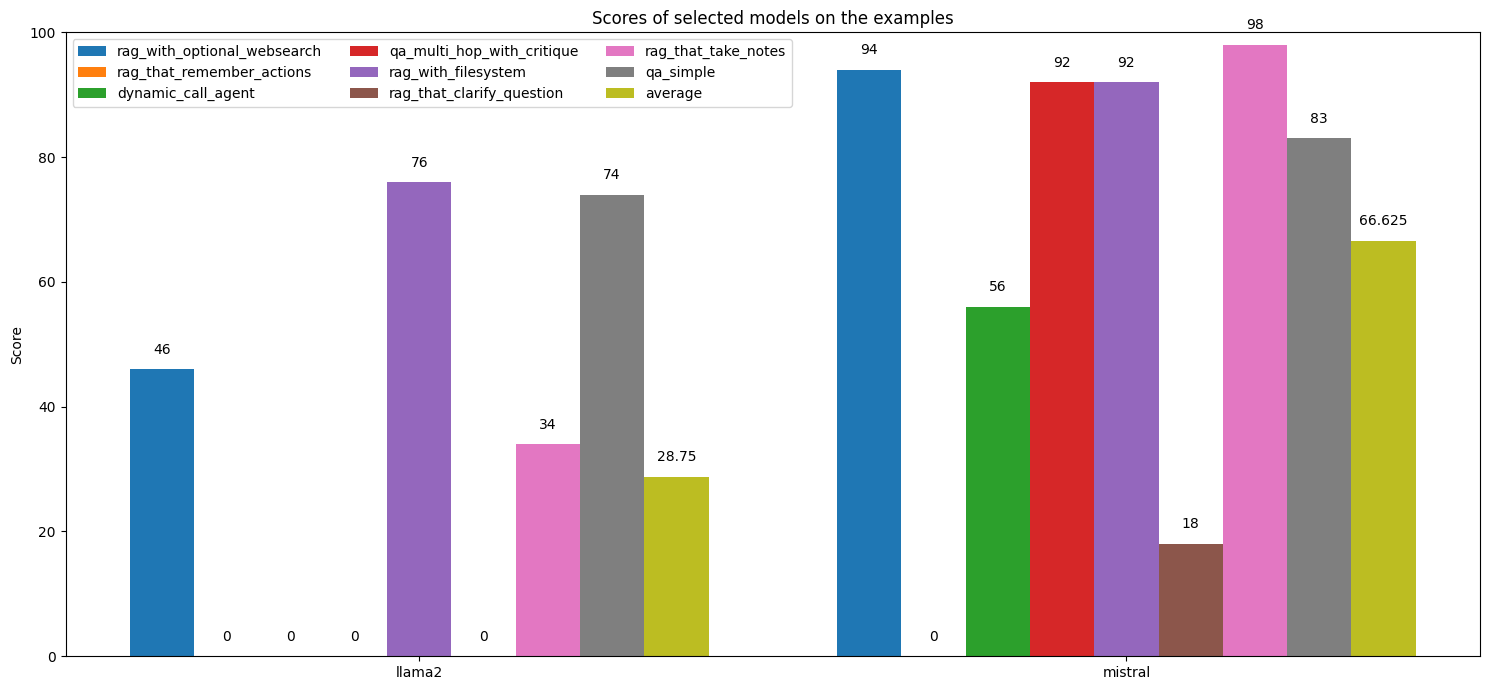

In [59]:
results2 = results.transpose()

gap = 2
x = np.arange(len(results2.columns))
width = 1/(len(results2)+gap)
fig, ax = plt.subplots(layout="constrained", figsize=(15, 7))

for multiplier, (exp_name, exp_data) in enumerate(results2.iterrows()):
    offset = width * multiplier
    rects = ax.bar(x+offset, exp_data, width, label=exp_name)
    ax.bar_label(rects, padding=len(results2))

ax.set_ylabel("Score")
ax.set_title("Scores of selected models on the examples")
ax.set_xticks(x + width*((len(results2)-1)/2), results2.columns)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

[]

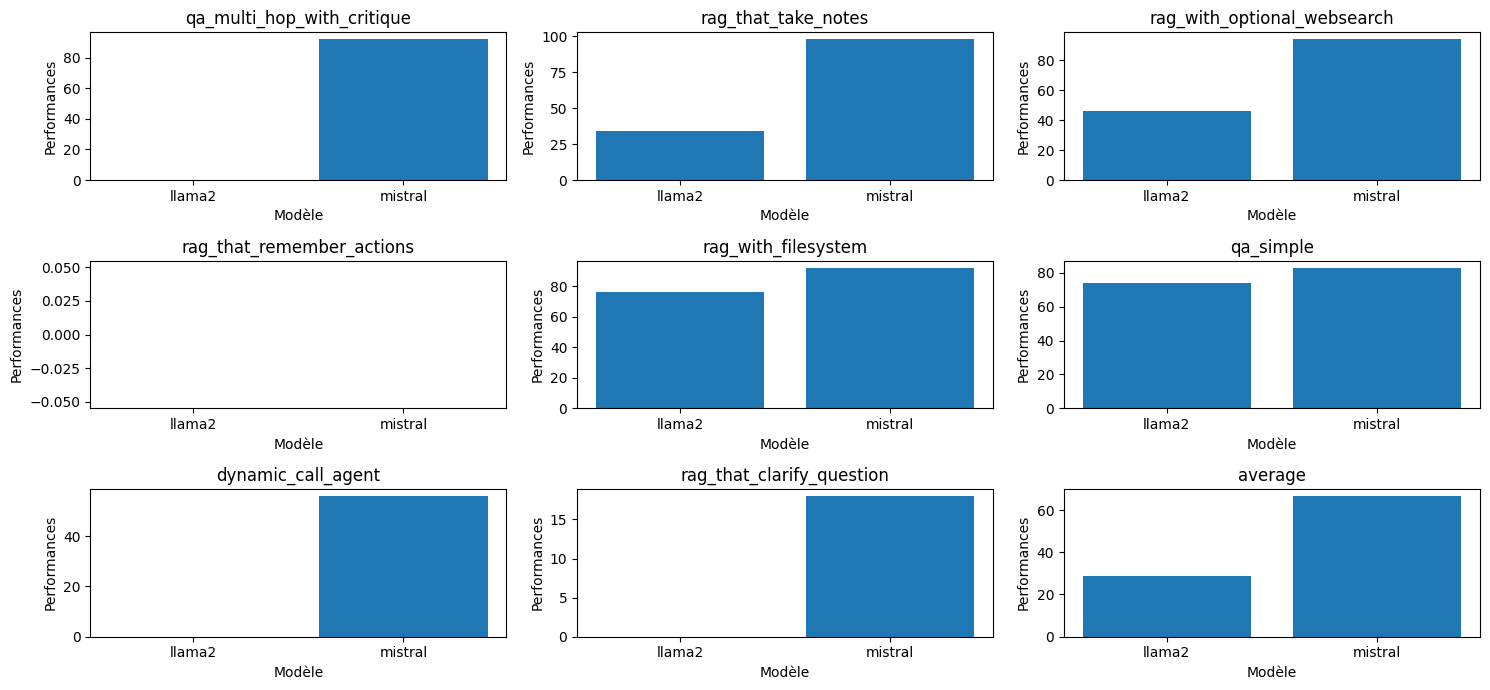

In [17]:
results2 = results.transpose()

fig, axes = plt.subplots(nrows=math.ceil(len(results2)/3), ncols=len(results2)//3, figsize=(15, 7))

for i, (exp_name, exp_data) in enumerate(results2.iterrows()):
    ax = axes[i%3][(i-1)//3]
    ax.bar(exp_data.index, exp_data.values)
    ax.set_title(exp_name)
    ax.set_xlabel('Modèle')
    ax.set_ylabel('Performances')

plt.tight_layout()
plt.plot()